# Bootstrap

Steps to produce data for this notebook:

```sh
# Generate samples using CLgen:
$ cd ~/src/project_b/bootstrap && ./01-create-programs.sh

# Rename function signature to match cl_launcher requirements:
$ cd ~/src/project_b/bootstrap && ./02-rename-samples.sh

# Import samples into MySQL dataset:
$ cd ~/src/project_b/bootstrap && ./03-run-samples.sh

# Run GPUVerify on the imported programs:
$ cd ~/src/project_b/difftest && lmk './clgen-gpuverify.py'

# Get the platform and device indices of available OpenCL platforms and devices:
$ cldrive --clinfo

# Run the kernels in MySQL dataset on a specific device:
$ cd ~/src/project_b/difftest && lmk './run_programs.py 1 0'

# Analayze results to compute outcomes and classifications:
$ cd ~/src/project_b/difftest && ./analyze.sh

# Hand-check suspicious programs:
$ cd ~/src/project_b/difftest && ./handcheck.sh
```

Then run this notebook.

In [1]:
import db as db
import sqlalchemy as sql
from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

In [2]:
s = db.make_session()

TABLE_NAME = "CLSmith w. cl_launcher"
TABLE = cl_launcherCLgenResult

num_results = s.query(TABLE).count()
num_programs = s.query(TABLE.program_id).group_by(TABLE.program_id).count()
num_devices = s.query(TABLE.testbed_id).group_by(TABLE.testbed_id).count()
num_params = s.query(TABLE.params_id).group_by(TABLE.params_id).count()

print(f"{num_results} results, {num_programs} programs, "
      f"{num_devices} devices, {num_params} params")

47700 results, 2385 programs, 5 devices, 4 params


In [3]:
max_programs = s.query(CLgenProgram).filter(CLgenProgram.cl_launchable == 1).count()
max_verified = s.query(CLgenProgram).filter(CLgenProgram.cl_launchable == 1,
                                            CLgenProgram.gpuverified == 1).count()
ratio_verified = max_verified / max_programs
print(f"{max_programs} programs, {max_verified} ({ratio_verified:.1%}) verified")

max_params = s.query(cl_launcherParams).count()
max_programs = s.query(CLgenProgram).filter(CLgenProgram.cl_launchable == 1).count()
max_results_per_testbed = max_params * max_programs
print(f"{max_results_per_testbed} results expected per testbed")

2385 programs, 885 (37.1%) verified
9540 results expected per testbed


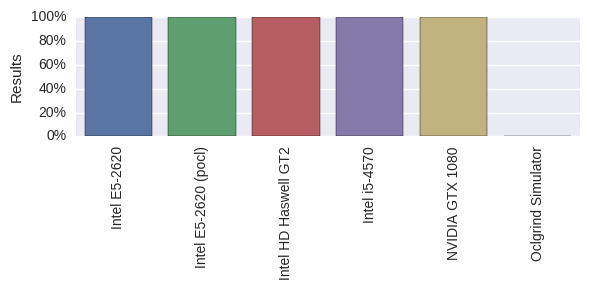

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from labm8 import viz
from operator import itemgetter
%matplotlib inline

# build table of number of number of results for each device+params combination:
# TODO: stacked table based on classification
rows = []
columns = ["Device", "Results"]
for testbed in s.query(Testbed).distinct():
        num_results = s.query(TABLE).filter(TABLE.testbed_id == testbed.id).count()
        rows.append((device_str(testbed.device), num_results / max_results_per_testbed))

ax = sns.barplot(data=pd.DataFrame(sorted(rows, key=itemgetter(0)), columns=columns),
                 x="Device", y="Results")
plt.xlabel("")
plt.ylabel("Results")
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
viz.finalise(figsize=(6,3))

In [5]:
# Table of outcomes per device
rows = []
columns = ["Device", "Outcome", "Count", "% of Results for Device"]

testbeds_with_results = s.query(Testbed).distinct()\
    .join(TABLE, TABLE.testbed_id == Testbed.id).all()

for testbed in testbeds_with_results:
    nresult = s.query(TABLE)\
        .filter(TABLE.testbed == testbed).count()

    ratios, labels = [], []
    outcomes = s.query(TABLE.outcome, sql.func.count(TABLE.outcome))\
        .filter(TABLE.testbed == testbed).group_by(TABLE.outcome)\
        .order_by(sql.desc(sql.func.count(TABLE.outcome)))

    rows += [(device_str(testbed.device), outcome, count, (count / nresult) * 100)
             for outcome, count in outcomes]

pd.DataFrame(rows, columns=columns)

,Device,Outcome,Count,% of Results for Device
0,NVIDIA GTX 1080,CL_INVALID_KERNEL_NAME,4534,47.526205
1,NVIDIA GTX 1080,CL_INVALID_KERNEL_ARGS,2196,23.018868
2,NVIDIA GTX 1080,Error building program: -42,1078,11.299790
3,NVIDIA GTX 1080,CL_BUILD_PROGRAM _FAILURE,672,7.044025
4,NVIDIA GTX 1080,Error setting kernel argument,520,5.450734
5,NVIDIA GTX 1080,z_Okay,508,5.324948
6,NVIDIA GTX 1080,Error enqueueing kernel,20,0.209644
7,NVIDIA GTX 1080,Segmentation Fault,8,0.083857
8,NVIDIA GTX 1080,Timeout,4,0.041929
9,Intel E5-2620,CL_INVALID_KERNEL_NAME,4524,47.421384


In [6]:
# Table of classifications per device, a la CLSmith paper
CLASSIFICATIONS = ["w", "bf", "c", "to", "nm", "✔", "it", "-"]

rows = []
columns = ["Device", "opt"] + CLASSIFICATIONS + ["w%", "bf%", "c%", "✔%"]

classifications_map = {
    "it": "Invalid testcase",
    "✔": "Okay",
    "bf": "Build failure",
    "w": "Wrong code",
    "nm": "No majority",
    "c": "Runtime crash",
    "to": "Timeout",
    "-": None,
}

testbeds_with_results = s.query(Testbed).distinct()\
    .join(TABLE, TABLE.testbed_id == Testbed.id).all()
    
for testbed in testbeds_with_results:
#     params_with_results = s.query(cl_launcherParams).distinct()\
#         .join(TABLE, TABLE.params_id == cl_launcherParams.id).all()
    optimizations = [False, True]

    for opt in optimizations:
        nresult = s.query(TABLE).filter(TABLE.testbed == testbed).count()

        ratios, labels = [], []
        classifications = dict(
            (classification, count) for classification, count in
            s.query(TABLE.classification, sql.func.count(TABLE.classification))\
                .join(cl_launcherParams, cl_launcherParams.id == TABLE.params_id)
                .filter(TABLE.testbed == testbed,
                        cl_launcherParams.optimizations == opt)\
                .group_by(TABLE.classification)\
                .order_by(sql.desc(sql.func.count(TABLE.classification))))

        row = dict((c, classifications.get(classifications_map[c], 0)) for c in CLASSIFICATIONS)
        row["Device"] = device_str(testbed.device)
        row["opt"] = "+" if opt else "-"
        
        # Same as in CLSmith paper:
        valid_testcases = max(row["w"] + row["bf"] + row["c"] + row["to"] + row["nm"] + row["✔"], 1)
        row["w%"] = "{:.1%}".format(row["w"] / max(row["✔"], 1))
        row["bf%"] = "{:.1%}".format(row["bf"] / valid_testcases)
        row["c%"] = "{:.1%}".format(row["c"] / valid_testcases)
        row["✔%"] = "{:.1%}".format(row["✔"] / valid_testcases)

        rows.append(row)

table = pd.DataFrame(rows, columns=columns)
table

,Device,opt,w,bf,c,to,nm,✔,it,-,w%,bf%,c%,✔%
0,NVIDIA GTX 1080,-,9,2586,0,2,17,228,1928,0,3.9%,91.0%,0.0%,8.0%
1,NVIDIA GTX 1080,+,6,2628,0,2,20,228,1886,0,2.6%,91.1%,0.0%,7.9%
2,Intel E5-2620,-,1,3108,0,2,17,234,1408,0,0.4%,92.4%,0.0%,7.0%
3,Intel E5-2620,+,1,3150,0,3,20,230,1366,0,0.4%,92.5%,0.0%,6.8%
4,Intel i5-4570,-,1,3108,0,2,17,234,1408,0,0.4%,92.4%,0.0%,7.0%
5,Intel i5-4570,+,1,3150,0,2,20,231,1366,0,0.4%,92.5%,0.0%,6.8%
6,Intel E5-2620 (pocl),-,1,2929,85,2,13,274,1466,0,0.4%,88.7%,2.6%,8.3%
7,Intel E5-2620 (pocl),+,0,2929,85,0,18,272,1466,0,0.0%,88.7%,2.6%,8.2%
8,Intel HD Haswell GT2,-,10,3126,16,10,17,229,1362,0,4.4%,91.7%,0.5%,6.7%
9,Intel HD Haswell GT2,+,6,3126,16,10,22,228,1362,0,2.6%,91.7%,0.5%,6.7%


In [7]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
import os
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/bootstrap.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/bootstrap.tex" && git push
table

remote: Counting objects: 7, done
remote: Finding sources: 100% (4/4)
remote: Getting sizes: 100% (6/6)
remote: Compressing objects: 100% (1251/1251)
remote: Total 4 (delta 2), reused 0 (delta 0)
Unpacking objects: 100% (4/4), done.
From https://git.overleaf.com/8608915dsywxshwwjmw
   d3df104..69dcb68  master     -> origin/master
First, rewinding head to replay your work on top of it...
Fast-forwarded master to 69dcb68990ba3a53636b66c0e6f96268306fce68.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,Device,opt,w,bf,c,to,nm,✔,it,-,w%,bf%,c%,✔%
0,NVIDIA GTX 1080,-,9,2586,0,2,17,228,1928,0,3.9%,91.0%,0.0%,8.0%
1,NVIDIA GTX 1080,+,6,2628,0,2,20,228,1886,0,2.6%,91.1%,0.0%,7.9%
2,Intel E5-2620,-,1,3108,0,2,17,234,1408,0,0.4%,92.4%,0.0%,7.0%
3,Intel E5-2620,+,1,3150,0,3,20,230,1366,0,0.4%,92.5%,0.0%,6.8%
4,Intel i5-4570,-,1,3108,0,2,17,234,1408,0,0.4%,92.4%,0.0%,7.0%
5,Intel i5-4570,+,1,3150,0,2,20,231,1366,0,0.4%,92.5%,0.0%,6.8%
6,Intel E5-2620 (pocl),-,1,2929,85,2,13,274,1466,0,0.4%,88.7%,2.6%,8.3%
7,Intel E5-2620 (pocl),+,0,2929,85,0,18,272,1466,0,0.0%,88.7%,2.6%,8.2%
8,Intel HD Haswell GT2,-,10,3126,16,10,17,229,1362,0,4.4%,91.7%,0.5%,6.7%
9,Intel HD Haswell GT2,+,6,3126,16,10,22,228,1362,0,2.6%,91.7%,0.5%,6.7%


In [8]:
from collections import Counter


def summarize_cl_launcher_stdout(stdout):
    """
    attempt to shorten output
    """
    if stdout.startswith("[UNKNOWN]"):
        return stdout

    components = [int(x, 0) for x in stdout.split(",") if x != ""]
    if len(components) <= 1:
        return f"'{stdout}'"
    
    buff = []
    counter = 1
    curr = components[0]
    for i in range(1, len(components)):
        if components[i] == curr:
            counter += 1
        else:
            if counter > 1:
                buff.append(f"'{curr},' x {counter}")
            else:
                buff.append(f"'{curr},'")
            counter = 1
            curr = components[i]
    
    if counter > 1:
        buff.append(f"'{curr},' x {counter}")
    else:
        buff.append(f"'{curr},'")    
    return '\n                   '.join(buff)


def generate_report_base(result):
    return f"""\
[Metadata]
Result ID:         {result.id}
Testbed ID:        {result.testbed_id}
Params ID:         {result.params_id}
Program ID:        {result.program_id}

[Testbed]
OpenCL Platform:   {result.testbed.platform}
OpenCL Device:     {result.testbed.device}
Driver version:    {result.testbed.driver}
OpenCL version:    {result.testbed.opencl}
Operating System:  {result.testbed.host}
"""


def generate_wrong_code_report(result):
    results = s.query(cl_launcherCLgenResult)\
        .filter(TABLE.program == result.program,
                TABLE.params == result.params,
                TABLE.status == 0).all()
    
    if len(results) > 2:
        # Use voting to pick oracle.
        outputs = [r.stdout for r in results]
        majority_output, majority_count = Counter(outputs).most_common(1)[0]
    elif len(results) == 2:
        if results[0].stdout != results[1].stdout:
            majority_count = 1
            ndistinct = len(results)
            majority_output = f"[UNKNOWN] ({ndistinct} distinct outputs)"
        else:
            majority_count = 2

    majority_devices = [
        r.testbed for r in results if r.stdout == majority_output
    ]
    minority_devices = [
        r.testbed for r in results if r.stdout != majority_output
    ]
    minority_count = len(minority_devices)
    
    if result.testbed in majority_devices:
        return

    majority_str = "    - " + "\n    - ".join(t.device for t in majority_devices)
    minority_str = "    - " + "\n    - ".join(t.device for t in minority_devices)

    program_output = summarize_cl_launcher_stdout(result.stdout)
    expected_output = summarize_cl_launcher_stdout(majority_output)
    
    return generate_report_base(result) + f"""

[Kernel]
{result.program.src}

[Parameters]    
Global size:       {result.params.gsize}
Workgroup size:    {result.params.lsize}
Optimizations:     {result.params.optimizations_on_off}

[Output]
Program output:    {program_output}
Expected output:   {expected_output}

Majority devices ({majority_count}):
{majority_str}

Minority devices ({minority_count}):
{minority_str}
"""
# Steps to reproduce:
#     $ ./cl_launcher {result.flags}

In [14]:
# Generate wrong-code reports for all *handchecked* programs.
#
# To handcheck programs, run $ cd ../difftest && ./handcheck.py
#
wrong_code_results = s.query(TABLE)\
    .filter(TABLE.classification == "Wrong code")\
    .join(CLgenProgram, CLgenProgram.id == TABLE.program_id)\
    .join(cl_launcherParams, cl_launcherParams.id == TABLE.params_id)\
    .filter(CLgenProgram.handchecked == 1)
    # To filter only testcases with global size and workgroup size 1:
    # .filter(sql.or_(cl_launcherParams.id == 4, cl_launcherParams.id == 3))\

print("#. wrong code reports:", wrong_code_results.count(), "\n")

for result in wrong_code_results:
    report = generate_wrong_code_report(result)
    if report:
        print(report)
        print("***************************************\n")

#. wrong code reports: 9 

[Metadata]
Result ID:         28649
Testbed ID:        3
Params ID:         2
Program ID:        2fdd7b6c359cfa36882788237a9362115990b617

[Testbed]
OpenCL Platform:   NVIDIA CUDA
OpenCL Device:     GeForce GTX 1080
Driver version:    375.39
OpenCL version:    1.2
Operating System:  Ubuntu 16.04 64bit


[Kernel]
__kernel void entry(__global int* a) {
  a[get_global_id(0)] = get_global_id(1);
}

[Parameters]    
Global size:       (128, 16, 1)
Workgroup size:    (32, 1, 1)
Optimizations:     off

[Output]
Program output:    '21474836485,' x 48
                   '64424509455,' x 16
                   '0,' x 1984
Expected output:   '64424509455,' x 64
                   '0,' x 1984

Majority devices (4):
    - Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz
    - Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz
    - Intel(R) HD Graphics Haswell GT2 Desktop
    - pthread-Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz

Minority devices (1):
    - GeForce GTX 1080

*****************